### Imports

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load and Split the Data

In [9]:
# Load dataset
file_path = "./bike-sharing-dataset/hour.csv"
df = pd.read_csv(file_path)

df = df.drop(["dteday", "instant", "casual", "registered"], axis=1)

# Define X and y (target)
X = df.drop(columns=['cnt'])  # All features except target
y = df['cnt']  # Target column

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Create Pipelines for Different Evaluation

In [10]:
# Basic pipeline function
def basic_pipeline(X_train, y_train, X_test, y_test):
    rf = RandomForestRegressor(random_state=42, n_estimators=100)  # Default hyperparameters
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return rf, mse, mae, r2, y_pred

#### Adding Scaling, Outlier Detection and Hyperparameter Tuning

**Scaling the data**

By implementing `StandardScaler` we are scaling the features in our dataset, which standardizes them to have a mean of 0 and a standard deviation of 1.
This is a good enhancment to try since it can help with:
- Model estability: ML Moles like Random Forest, tend to perform better when features are on a similar scale, as it prevents bias towards features with larger ranges
- Outlier detection: Standardazing the data helps isolate extreme values more effectively when doing outlier detection (which is the next enhacement)

**Outlier detection**

This code removes outliers in the training data using the Interquartile Range (`IQR`) method. It calculates the first (Q1) and third (Q3) quartiles, finds the IQR (Q3 - Q1), and flags rows with values outside the typical range (1.5 times the IQR). These rows are excluded from the training set.
With this change we are trying to improve:
- Model stability: Removes extreme values that could skew results.
- Simplifies learning: Helps the model focus on typical patterns in the data.

**Hyperparameter tuning**

In [18]:
# Enhanced pipeline with scaling, outlier detection, and hyperparameter tuning
def enhanced_pipeline(X_train, y_train, X_test, y_test):
    # Random Forest with hyperparameter tuning
    rf = RandomForestRegressor(random_state=42)

    param_grid = {
      'n_estimators': [100, 150, 200],
      'max_depth': [15, 20, 25],
      'max_features': ['sqrt'],
      'min_samples_split': [2, 3],
      'min_samples_leaf': [1, 2]
    }

    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, error_score='raise')
    grid_search.fit(X_train, y_train)
    best_rf = grid_search.best_estimator_

    # Predictions and evaluation
    y_pred = best_rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Best Parameters: {grid_search.best_params_}")

    return best_rf, mse, mae, r2, y_pred

### Run the Pipelines

Note: This will take some time to run

In [19]:
basic_model, basic_mse, basic_mae, basic_r2, basic_y_pred = basic_pipeline(X_train, y_train, X_test, y_test)
enhanced_model, enhanced_mse, enhanced_mae, enhanced_r2, enhanced_y_pred = enhanced_pipeline(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   1.6s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   1.7s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=15

### Compare results

In [22]:
print("Basic Pipeline:")
print(f"Mean Squared Error: {basic_mse:.2f}")
print(f"Mean Squared Error: {basic_mae:.2f}")
print(f"R-Squared: {basic_r2:.2f}")

print("\nEnhanced Pipeline:")
print(f"Mean Squared Error: {enhanced_mse:.2f}")
print(f"Mean Squared Error: {enhanced_mae:.2f}")
print(f"R-Squared: {enhanced_r2:.2f}")

Basic Pipeline:
Mean Squared Error: 1769.84
Mean Squared Error: 24.90
R-Squared: 0.94

Enhanced Pipeline:
Mean Squared Error: 3276.48
Mean Squared Error: 37.47
R-Squared: 0.90


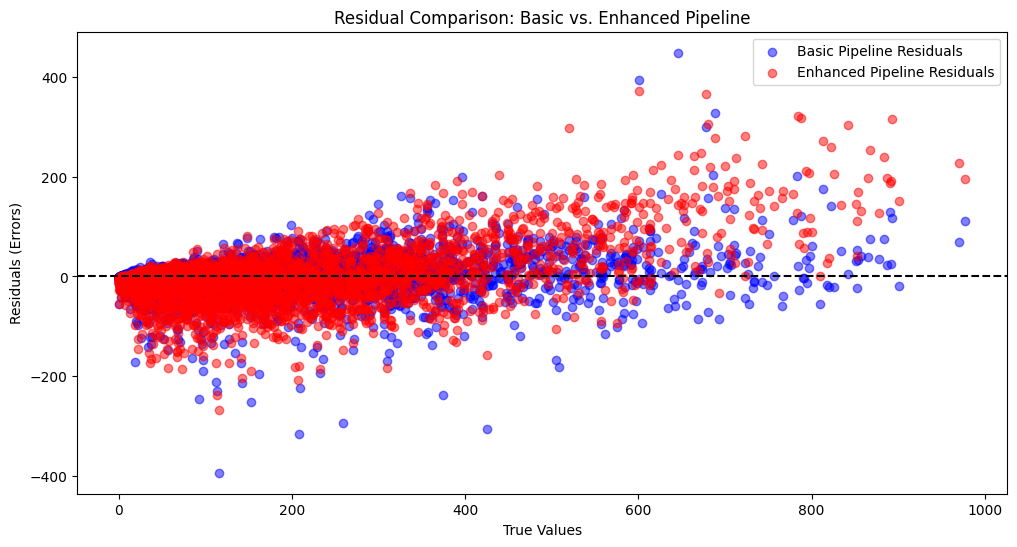

Mean Absolute Error (Enhanced Pipeline): 37.47
Error statistics by range:
cnt
(0.024, 196.2]    2191
(196.2, 391.4]     856
(391.4, 586.6]     287
(586.6, 781.8]     107
(781.8, 977.0]      35
Name: count, dtype: int64


In [23]:
# Plot residuals (errors) for comparison
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_test - basic_y_pred, color="blue", alpha=0.5, label="Basic Pipeline Residuals")
plt.scatter(y_test, y_test - enhanced_y_pred, color="red", alpha=0.5, label="Enhanced Pipeline Residuals")
plt.axhline(0, linestyle="--", color="black")
plt.xlabel("True Values")
plt.ylabel("Residuals (Errors)")
plt.legend()
plt.title("Residual Comparison: Basic vs. Enhanced Pipeline")
plt.show()

# Identify clusters or ranges of failure
error_enhanced = y_test - enhanced_y_pred
print(f"Mean Absolute Error (Enhanced Pipeline): {abs(error_enhanced).mean():.2f}")
print("Error statistics by range:")
print(pd.cut(y_test, bins=5).value_counts())